In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle

plt.style.use('ggplot')

In [2]:
cd ..

/Users/odatakuma/cmu/FleetAI


In [3]:
data_path = 'analytics/data/taxi_trips/taxi_tripdata_2016-05.csv'

In [4]:
cols = ['dayofweek', 'hour', 'pickup_zone', 'dropoff_zone']
df = pd.read_csv(data_path, usecols=cols, dtype={key : np.int32 for key in cols}).reset_index()
df = df.rename(columns={'index':'p'})
df = df[(df.pickup_zone>0)&(df.dropoff_zone>0)]
df.head()

,p,dayofweek,hour,pickup_zone,dropoff_zone
0,0,6,0,47,78
1,1,6,0,89,169
2,2,6,0,24,248
3,3,6,0,89,162
4,4,6,0,67,89


In [5]:
df = df.groupby(['dayofweek', 'hour', 'pickup_zone', 'dropoff_zone'])['p'].count()
df = df.reset_index()
df.head()

,dayofweek,hour,pickup_zone,dropoff_zone,p
0,0,0,2,207,1
1,0,0,2,247,1
2,0,0,3,3,5
3,0,0,3,6,3
4,0,0,3,13,1


In [7]:
df['dayofweek_hour_pickup'] = zip(df.dayofweek, df.hour, df.pickup_zone)
df_pivot = df.pivot(index='dayofweek_hour_pickup', columns='dropoff_zone', values='p')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

dropoff_zone,2,3,6,7,8,9,10,11,12,13,...,253,254,255,256,257,258,259,260,261,262
dayofweek_hour_pickup,,,,,,,,,,,,,,,,,,,,,
"(0, 0, 2)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 0, 3)",0,5,3,0,0,0,0,0,0,1,...,0,4,2,0,0,0,0,1,2,2
"(0, 0, 6)",0,1,132,2,0,1,0,0,0,0,...,0,1,0,0,1,0,29,0,1,1
"(0, 0, 9)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 0, 11)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
taxi_zones = sorted(df.pickup_zone.unique())
dayofweek0 = df['dayofweek'].iloc[0]

In [9]:
df_od = pd.DataFrame(index=[((dayofweek0+d)%7, h, z) for d in range(7) for h in range(24) for z in taxi_zones],
                    columns=taxi_zones)
df_od.loc[df_pivot.index] = df_pivot
df_od = df_od.fillna(0) + 0.1
df_od.iloc[:, :] = [p / p.sum() for p in df_od.values]
df_od.head()

,2,3,6,7,8,9,10,11,12,13,...,253,254,255,256,257,258,259,260,261,262
"(0, 0, 2)",0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,...,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149
"(0, 0, 3)",0.000565,0.028797,0.017504,0.000565,0.000565,0.000565,0.000565,0.000565,0.000565,0.006211,...,0.000565,0.023151,0.011858,0.000565,0.000565,0.000565,0.000565,0.006211,0.011858,0.011858
"(0, 0, 6)",0.000158,0.001743,0.209317,0.003328,0.000158,0.001743,0.000158,0.000158,0.000158,0.000158,...,0.000158,0.001743,0.000158,0.000158,0.001743,0.000158,0.046110,0.000158,0.001743,0.001743
"(0, 0, 7)",0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,...,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525
"(0, 0, 8)",0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,...,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525


In [13]:
for key in ['dayofweek', 'hour', 'pickup_zone']:
    df_od[key] = 0

In [16]:
df_od.loc[:, ['dayofweek', 'hour', 'pickup_zone']] = list(df_od.index)
df_od = df_od.reset_index().drop('index', axis=1)
df_od.head()

,2,3,6,7,8,9,10,11,12,13,...,256,257,258,259,260,261,262,dayofweek,hour,pickup_zone
0,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,...,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0.004149,0,0,2
1,0.000565,0.028797,0.017504,0.000565,0.000565,0.000565,0.000565,0.000565,0.000565,0.006211,...,0.000565,0.000565,0.000565,0.000565,0.006211,0.011858,0.011858,0,0,3
2,0.000158,0.001743,0.209317,0.003328,0.000158,0.001743,0.000158,0.000158,0.000158,0.000158,...,0.000158,0.001743,0.000158,0.046110,0.000158,0.001743,0.001743,0,0,6
3,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,...,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0,0,7
4,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,...,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0.004525,0,0,8


In [18]:
df_od = df_od.set_index(['dayofweek', 'hour', 'pickup_zone'])
df_od.head()

2         3         6         7         8    \
dayofweek hour pickup_zone                                                     
0         0    2            0.004149  0.004149  0.004149  0.004149  0.004149   
               3            0.000565  0.028797  0.017504  0.000565  0.000565   
               6            0.000158  0.001743  0.209317  0.003328  0.000158   
               7            0.004525  0.004525  0.004525  0.004525  0.004525   
               8            0.004525  0.004525  0.004525  0.004525  0.004525   

                                 9         10        11        12        13   \
dayofweek hour pickup_zone                                                     
0         0    2            0.004149  0.004149  0.004149  0.004149  0.004149   
               3            0.000565  0.000565  0.000565  0.000565  0.006211   
               6            0.001743  0.000158  0.000158  0.000158  0.000158   
               7            0.004525  0.004525  0.004525  0.004525  0.004525   
               8            0.004525  0.004525  0.004525  0.004525  0.004525   

                              ...          253       254       255       256  \
dayofweek hour pickup_zone    ...                                              
0         0    2              ...     0.004149  0.004149  0.004149  0.004149   
               3              ...     0.000565  0.023151  0.011858  0.000565   
               6              ...     0.000158  0.001743  0.000158  0.000158   
               7              ...     0.004525  0.004525  0.004525  0.004525   
               8              ...     0.004525  0.004525  0.004525  0.004525   

                                 257       258       259       260       261  \
dayofweek hour pickup_zone                                                     
0         0    2            0.004149  0.004149  0.004149  0.004149  0.004149   
               3            0.000565  0.000565  0.000565  0.006211  0.011858   
               6            0.001743  0.000158  0.046110  0.000158  0.001743   
               7            0.004525  0.004525  0.004525  0.004525  0.004525   
               8            0.004525  0.004525  0.004525  0.004525  0.004525   

                                 262  
dayofweek hour pickup_zone            
0         0    2            0.004149  
               3            0.011858  
               6            0.001743  
               7            0.004525  
               8            0.004525  

[5 rows x 221 columns]

In [19]:
df_od.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37128 entries, (0, 0, 2) to (6, 23, 262)
Columns: 221 entries, 2 to 262
dtypes: float64(221)
memory usage: 62.9+ MB


In [20]:
df_od.to_csv('engine/data/pdest.csv')

In [24]:
df = pd.read_csv('engine/data/pdest.csv').set_index(['dayofweek', 'hour', 'pickup_zone'])
df.head()

2         3         6         7         8  \
dayofweek hour pickup_zone                                                     
0         0    2            0.004149  0.004149  0.004149  0.004149  0.004149   
               3            0.000565  0.028797  0.017504  0.000565  0.000565   
               6            0.000158  0.001743  0.209317  0.003328  0.000158   
               7            0.004525  0.004525  0.004525  0.004525  0.004525   
               8            0.004525  0.004525  0.004525  0.004525  0.004525   

                                   9        10        11        12        13  \
dayofweek hour pickup_zone                                                     
0         0    2            0.004149  0.004149  0.004149  0.004149  0.004149   
               3            0.000565  0.000565  0.000565  0.000565  0.006211   
               6            0.001743  0.000158  0.000158  0.000158  0.000158   
               7            0.004525  0.004525  0.004525  0.004525  0.004525   
               8            0.004525  0.004525  0.004525  0.004525  0.004525   

                              ...          253       254       255       256  \
dayofweek hour pickup_zone    ...                                              
0         0    2              ...     0.004149  0.004149  0.004149  0.004149   
               3              ...     0.000565  0.023151  0.011858  0.000565   
               6              ...     0.000158  0.001743  0.000158  0.000158   
               7              ...     0.004525  0.004525  0.004525  0.004525   
               8              ...     0.004525  0.004525  0.004525  0.004525   

                                 257       258       259       260       261  \
dayofweek hour pickup_zone                                                     
0         0    2            0.004149  0.004149  0.004149  0.004149  0.004149   
               3            0.000565  0.000565  0.000565  0.006211  0.011858   
               6            0.001743  0.000158  0.046110  0.000158  0.001743   
               7            0.004525  0.004525  0.004525  0.004525  0.004525   
               8            0.004525  0.004525  0.004525  0.004525  0.004525   

                                 262  
dayofweek hour pickup_zone            
0         0    2            0.004149  
               3            0.011858  
               6            0.001743  
               7            0.004525  
               8            0.004525  

[5 rows x 221 columns]

In [4]:
cols = ['dayofweek', 'hour', 'minute', 'pickup_latitude', 'pickup_longitude', 'dropoff_zone']
df = pd.read_csv(data_path, usecols=cols, dtype={key : np.float32 for key in cols})
df.head()

,dayofweek,hour,minute,pickup_latitude,pickup_longitude,dropoff_zone
0,6,0,0,40.768040,-73.985901,78
1,6,0,0,40.741573,-73.993073,169
2,6,0,0,40.684601,-73.991943,248
3,6,0,0,40.744751,-73.991577,162
4,6,0,0,40.740192,-74.005280,89


In [5]:
df = df[df.dropoff_zone>=0]
df['hour'] = df.hour + df.minute/60
df['dropoff_zone'] = df.dropoff_zone.astype(int)
df['weekend'] = (df.dayofweek > 4).astype(np.int32)
df['dayofweek_sin'] = np.sin(df.dayofweek/7.0).astype(np.float32)
df['dayofweek_cos'] = np.cos(df.dayofweek/7.0).astype(np.float32)
df['hour_sin'] = np.sin(df.hour/24.0).astype(np.float32)
df['hour_cos'] = np.cos(df.hour/24.0).astype(np.float32)
df = df.drop(['dayofweek', 'hour', 'minute'], axis=1)

zones = df.dropoff_zone.unique()
zones.sort()
zone2label = {zone:label for label, zone in enumerate(zones)}
df['label'] = df.dropoff_zone.map(lambda x: zone2label[x])

In [6]:
from sklearn.cross_validation import train_test_split

X = df.drop(['dropoff_zone', 'label'], axis=1).values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print X.shape

/Users/odatakuma/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(12874902, 7)


In [7]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense

def MLP(input_dim, hidden_dim, output_dim):
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(hidden_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

Using TensorFlow backend.


In [8]:
n_label = len(df.dropoff_zone.unique())
onehot_train = np.zeros((y_train.size, n_label), dtype=np.int8)
onehot_train[np.arange(y_train.size), y_train] = 1
onehot_test = np.zeros((y_test.size, n_label), dtype=np.int8)
onehot_test[np.arange(y_test.size), y_test] = 1

In [9]:
mlp = MLP(X_train.shape[1], 64, n_label)
mlp.fit(X_train, onehot_train, nb_epoch=5, batch_size=1000, verbose=2,
         validation_split=0.0)

Epoch 1/5
314s - loss: 4.4090
Epoch 2/5
318s - loss: 4.3314
Epoch 3/5
309s - loss: 4.2294
Epoch 4/5
311s - loss: 4.1944
Epoch 5/5
310s - loss: 4.1849


In [10]:
train_acc = (mlp.predict_classes(X_train, verbose=0) == y_train).mean()
test_acc = (mlp.predict_classes(X_test, verbose=0) == y_test).mean()
print "Accuracy train/test: %.3f / %.3f" % (train_acc, test_acc)

Accuracy train/test: 0.060 / 0.060


In [11]:
model_json = mlp.to_json()
with open("engine/model/dest_model/model.json", "w") as f:
    f.write(model_json)
# serialize weights to HDF5
mlp.save_weights("engine/model/dest_model/model.h5")
print("Saved model to disk")

Saved model to disk


In [9]:
from keras.models import model_from_json

# load json and create model
with open('engine/model/dest_model/model.json', 'r') as f:
    model = f.read()
model = model_from_json(model)
# load weights into new model
model.load_weights("engine/model/dest_model/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gbr = GradientBoostingClassifier(learning_rate=1.0, n_estimators=5, subsample=0.2, max_depth=2)
gbr.fit(X_train, y_train)
print gbr.score(X_train, y_train)
print gbr.score(X_test, y_test)
# train_acc = (mlp.predict(X_train) == y_train).mean()
# val_acc = (mlp.predict(X_val) == y_val).mean()
# print "Accuracy train/val: %.3f / %.3f" % (train_acc, val_acc)

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=2, min_samples_split=1e-4, n_jobs=-1)
forest.fit(X_train, y_train)
print forest.score(X_train, y_train)
print forest.score(X_test, y_test)

In [ ]:
%%time
forest.predict(X_test[:2])

In [13]:
from collections import Counter

c = Counter(y)

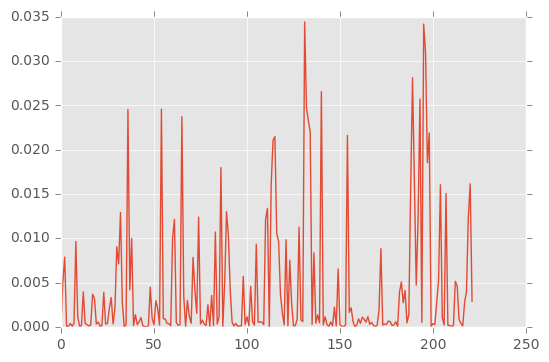

In [15]:
N = len(df)
p = [float(z)/N for z in c.values()]
plt.plot(range(len(p)), p)